In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from scipy import stats

%matplotlib inline

plt.style.use('ggplot')

### EDA

In [3]:
df = pd.read_csv("data/PJME_hourly.csv")
df = df.set_index("Datetime")

df.index = pd.to_datetime(df.index)

In [4]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


In [6]:
# Check for missing data
print(df.isnull().sum())

# Check for inf values
print(np.isinf(df).sum())

# Check for nan values
print(np.isnan(df).sum())

PJME_MW    0
dtype: int64
PJME_MW    0
dtype: int64
PJME_MW    0
dtype: int64


<Axes: title={'center': 'PJME_hourly'}, xlabel='Datetime'>

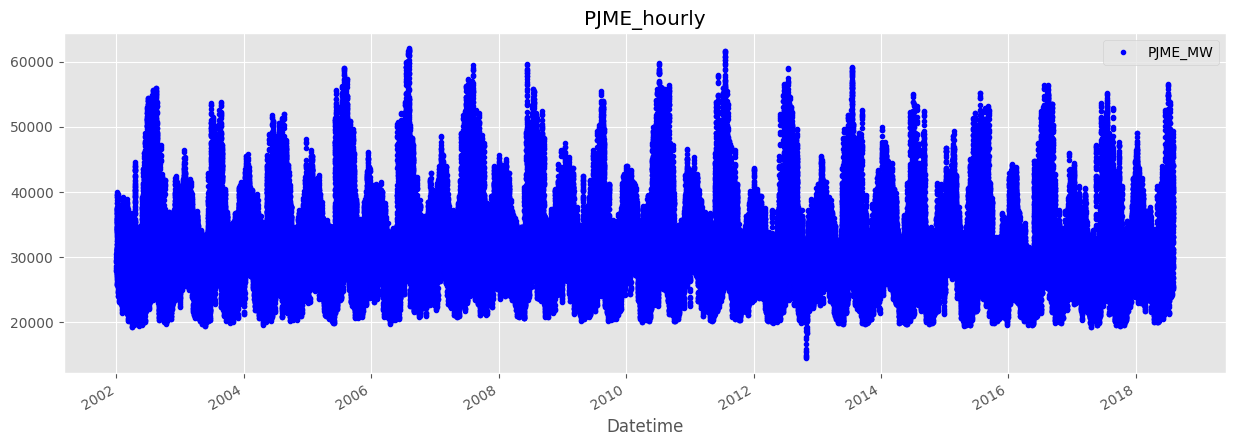

In [7]:
df.plot(style='.',
        figsize=(15,5),
        title = 'PJME_hourly', 
        color='b'
        )

<Axes: title={'center': 'PJME_hourly'}, xlabel='Datetime'>

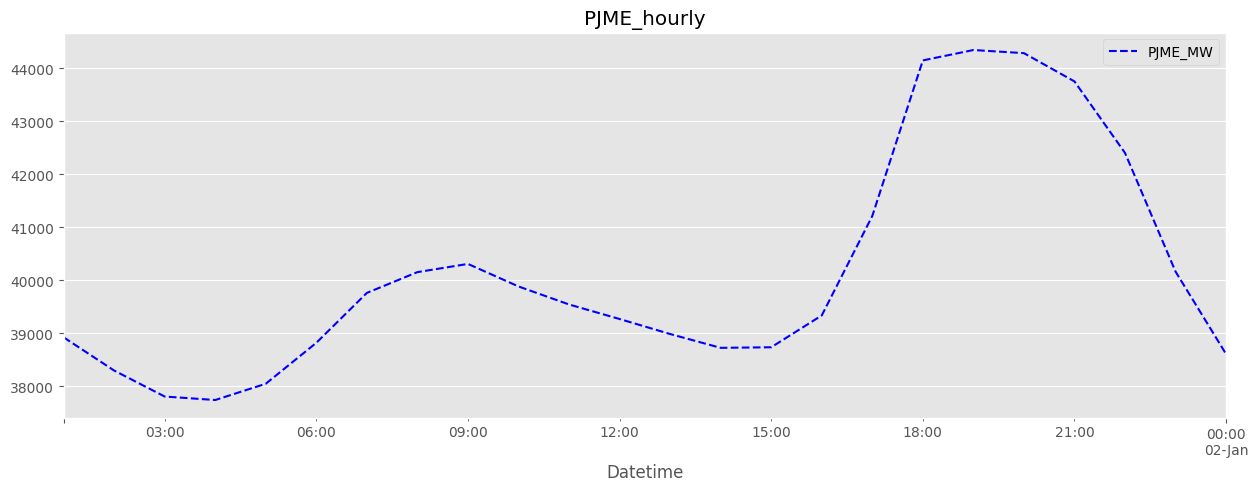

In [8]:
#predict last 24 hours + predict random 24 hours...
df.iloc[-24:].plot(style='--',
        figsize=(15,5),
        title = 'PJME_hourly', 
        color='b'
        )

In [9]:
df.index

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

# preprocessing + feature eng

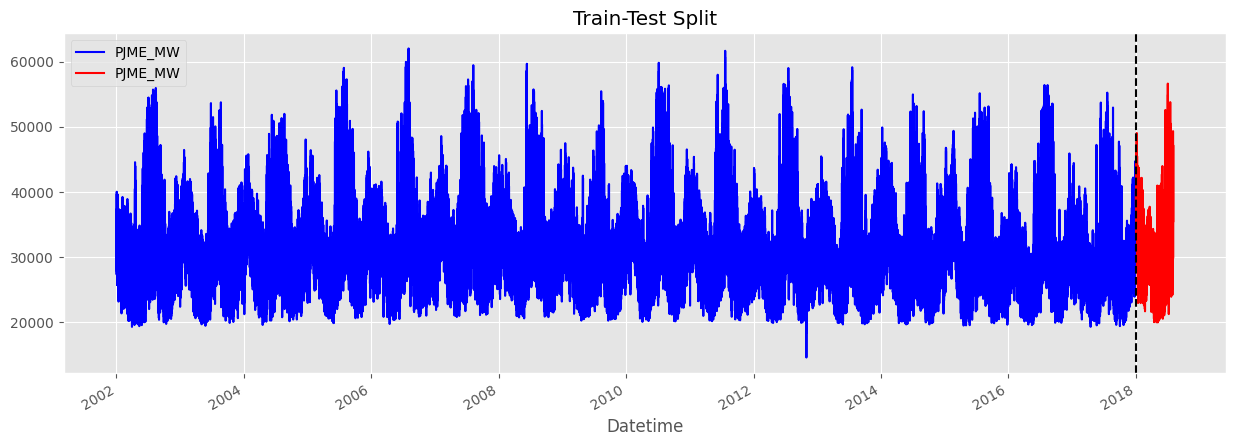

In [10]:
train = df.loc[df.index < '01-01-2018']
test = df.loc[df.index >= '01-01-2018']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label="Training Set", color='b')
test.plot(ax=ax, label="Test-Set", color = 'r')
ax.axvline('01-01-2018', color='black', ls='--')
plt.title("Train-Test Split")
plt.show()

In [12]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week.astype('int')
    df['moving_avg_7'] = df['PJME_MW'].rolling(window=7).mean()
    df['moving_avg_14'] = df['PJME_MW'].rolling(window=14).mean()
    df['moving_avg_30'] = df['PJME_MW'].rolling(window=30).mean()
    df['lag_1'] = df['PJME_MW'].shift(1)
    df['lag_2'] = df['PJME_MW'].shift(2)
    df.dropna(inplace=True)

    return df


In [13]:
create_features(df).columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear', 'moving_avg_7', 'moving_avg_14',
       'moving_avg_30', 'lag_1', 'lag_2'],
      dtype='object')

In [14]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


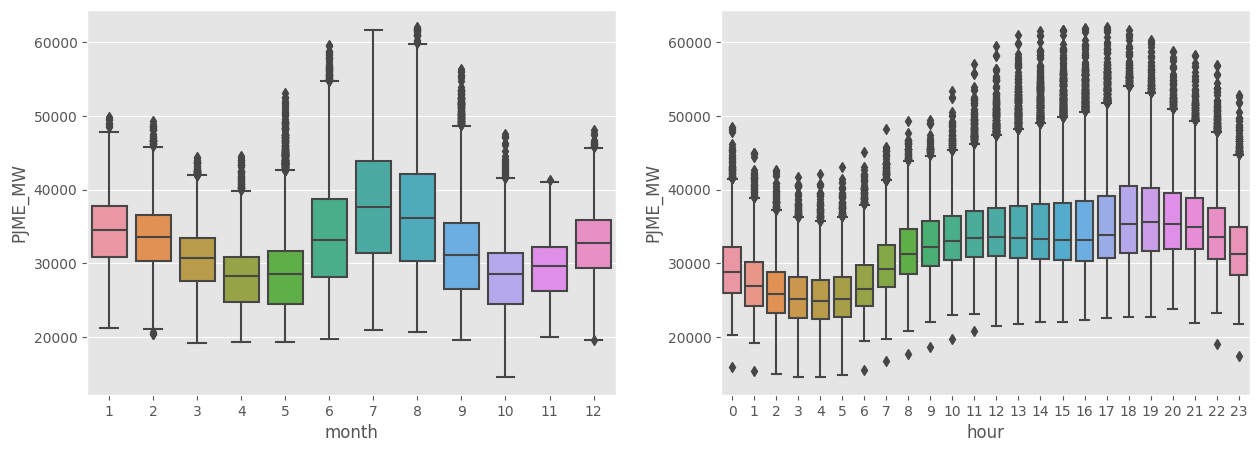

In [15]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

sns.boxplot(data=create_features(df), x = "month", y = "PJME_MW", ax=ax[0])
sns.boxplot(data=create_features(df), x = "hour", y = "PJME_MW",ax=ax[1])
plt.show()

In [16]:
train = create_features(train)
test = create_features(test)

In [17]:
features = ['hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear','moving_avg_7','moving_avg_14', 'moving_avg_30', 'lag_1', 'lag_2']
target = "PJME_MW"

In [18]:
X_train = train[features]
y_train = train[target] 

X_test = test[features]
y_test = test[target]

### Model training and predicting

### lightgbm model

In [20]:
parameters = {
    "max_depth": [3, 6, 10],
    "num_leaves": [10, 30, 100],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 500, 1000],
    "colsample_bytree": [0.3, 0.7, 1]
}

lgb_model_hyper = lgb.LGBMRegressor(boosting_type='gbdt', 
                              objective='regression')

grid_search = RandomizedSearchCV(estimator=lgb_model_hyper, param_distributions=parameters, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train, 
              eval_set=[(X_test, y_test)], 
              eval_metric='rmse')

[1]	valid_0's rmse: 5693.09	valid_0's l2: 3.24113e+07
[2]	valid_0's rmse: 5174.18	valid_0's l2: 2.67721e+07
[3]	valid_0's rmse: 4714.68	valid_0's l2: 2.22282e+07
[4]	valid_0's rmse: 4342.89	valid_0's l2: 1.88607e+07
[5]	valid_0's rmse: 3970.25	valid_0's l2: 1.57629e+07
[6]	valid_0's rmse: 3638.18	valid_0's l2: 1.32364e+07
[7]	valid_0's rmse: 3339.89	valid_0's l2: 1.11549e+07
[8]	valid_0's rmse: 3078.69	valid_0's l2: 9.4783e+06
[9]	valid_0's rmse: 2842.77	valid_0's l2: 8.08135e+06
[10]	valid_0's rmse: 2626.47	valid_0's l2: 6.89836e+06
[11]	valid_0's rmse: 2443.02	valid_0's l2: 5.96834e+06
[12]	valid_0's rmse: 2277.6	valid_0's l2: 5.18748e+06
[13]	valid_0's rmse: 2135.38	valid_0's l2: 4.55983e+06
[14]	valid_0's rmse: 2000.72	valid_0's l2: 4.00287e+06
[15]	valid_0's rmse: 1887.59	valid_0's l2: 3.56298e+06
[16]	valid_0's rmse: 1786.05	valid_0's l2: 3.18996e+06
[17]	valid_0's rmse: 1694.53	valid_0's l2: 2.87142e+06
[18]	valid_0's rmse: 1621.21	valid_0's l2: 2.62832e+06
[19]	valid_0's rmse: 

RandomizedSearchCV(estimator=LGBMRegressor(objective='regression'),
                   param_distributions={'colsample_bytree': [0.3, 0.7, 1],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 6, 10],
                                        'n_estimators': [100, 500, 1000],
                                        'num_leaves': [10, 30, 100]},
                   scoring='neg_mean_squared_error')

In [21]:
print("best estimator: ", grid_search.best_estimator_)
print("best params: ", grid_search.best_params_)
print("best score: ", grid_search.best_score_)

best estimator:  LGBMRegressor(colsample_bytree=0.7, max_depth=6, n_estimators=1000,
              num_leaves=100, objective='regression')
best params:  {'num_leaves': 100, 'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
best score:  -196497.1489753535


In [44]:
best_params = grid_search.best_params_
best_params

{'num_leaves': 100,
 'n_estimators': 1000,
 'max_depth': 6,
 'learning_rate': 0.1,
 'colsample_bytree': 0.7}

In [47]:
# create LGBMRegressor object

lgb_model = lgb.LGBMRegressor(boosting_type='gbdt', 
                              objective='regression',
                              **grid_search.best_params_)

# fit the model on training data
lgb_model.fit(X_train, y_train, 
              eval_set=[(X_test, y_test)], 
              eval_metric='rmse')

# predict on test data
y_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration_)

# calculate root mean squared error
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse:.2f}")
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred))
print("R2: ", r2_score(y_test, y_pred))

[1]	valid_0's rmse: 5672.56	valid_0's l2: 3.21779e+07
[2]	valid_0's rmse: 5134.9	valid_0's l2: 2.63672e+07
[3]	valid_0's rmse: 4651.59	valid_0's l2: 2.16373e+07
[4]	valid_0's rmse: 4237.66	valid_0's l2: 1.79578e+07
[5]	valid_0's rmse: 3846.21	valid_0's l2: 1.47934e+07
[6]	valid_0's rmse: 3493.38	valid_0's l2: 1.22037e+07
[7]	valid_0's rmse: 3182.4	valid_0's l2: 1.01277e+07
[8]	valid_0's rmse: 2899.68	valid_0's l2: 8.40817e+06
[9]	valid_0's rmse: 2651.18	valid_0's l2: 7.02873e+06
[10]	valid_0's rmse: 2428.17	valid_0's l2: 5.896e+06
[11]	valid_0's rmse: 2228.08	valid_0's l2: 4.96434e+06
[12]	valid_0's rmse: 2054.78	valid_0's l2: 4.22211e+06
[13]	valid_0's rmse: 1903.78	valid_0's l2: 3.62438e+06
[14]	valid_0's rmse: 1764	valid_0's l2: 3.11169e+06
[15]	valid_0's rmse: 1640.33	valid_0's l2: 2.69069e+06
[16]	valid_0's rmse: 1532.9	valid_0's l2: 2.34978e+06
[17]	valid_0's rmse: 1438.3	valid_0's l2: 2.0687e+06
[18]	valid_0's rmse: 1363.61	valid_0's l2: 1.85943e+06
[19]	valid_0's rmse: 1299.64	

In [40]:
r2_score(y_test, y_pred)

0.9930582649651538

In [24]:
test['prediction'] = lgb_model.predict(X_test)
df = df.merge(test['prediction'], how='left', left_index=True, right_index=True)

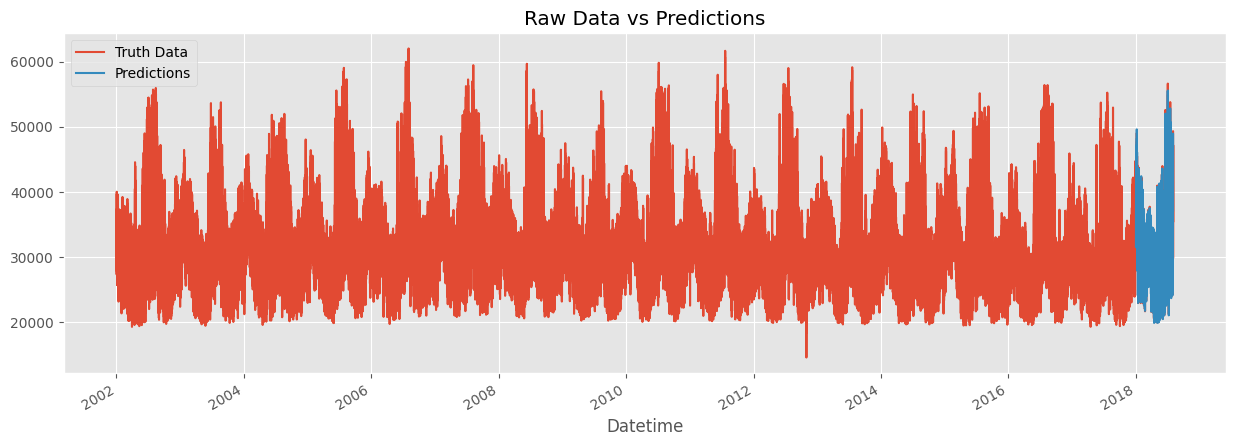

In [25]:
ax= df['PJME_MW'].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='-')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data vs Predictions')
plt.show()

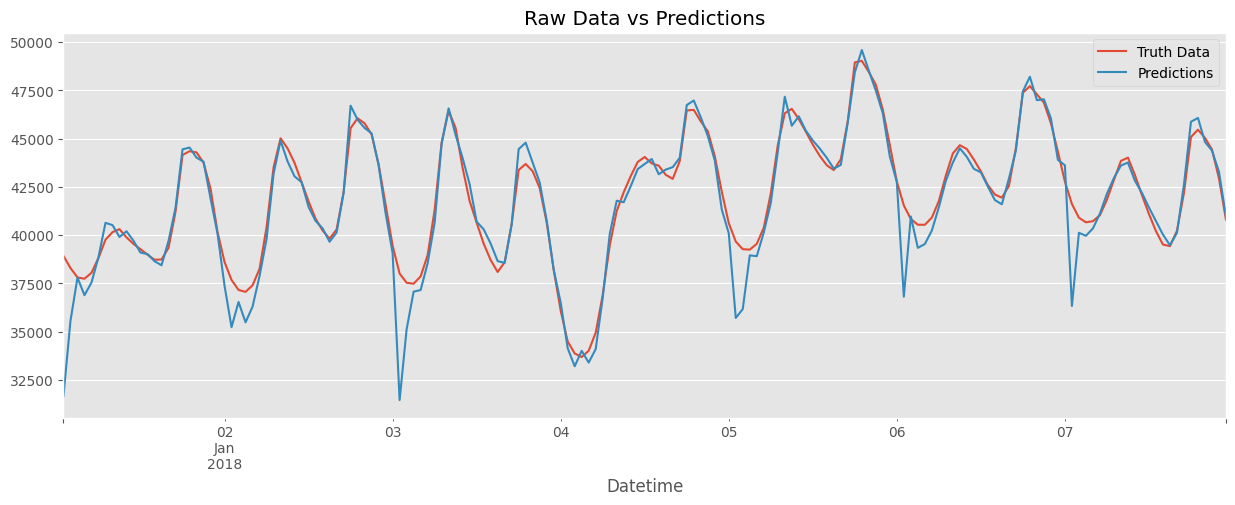

In [27]:
ax= df.loc[(df.index >'01-01-2018')&(df.index<'01-08-2018')]['PJME_MW'].plot(figsize=(15,5), title='Week of Data')
df.loc[(df.index >'01-01-2018')&(df.index<'01-08-2018')]['prediction'].plot(ax=ax, style='-')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data vs Predictions')
plt.show()

In [28]:
df[df["prediction"].isnull()==False]

,PJME_MW,prediction
Datetime,,
2018-01-01 01:00:00,38925.0,31670.255424
2018-01-01 02:00:00,38298.0,35561.847110
2018-01-01 03:00:00,37808.0,37798.696105
2018-01-01 04:00:00,37742.0,36891.213669
2018-01-01 05:00:00,38049.0,37543.534620
...,...,...
2018-08-01 20:00:00,46912.0,46267.060927
2018-08-01 21:00:00,45985.0,45708.907405
2018-08-01 22:00:00,44094.0,44221.159148


<Axes: xlabel='Datetime'>

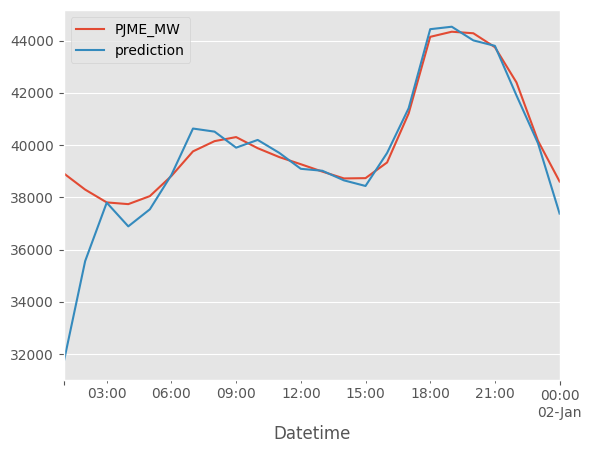

In [29]:
df[df["prediction"].isnull()==False][:24].plot()

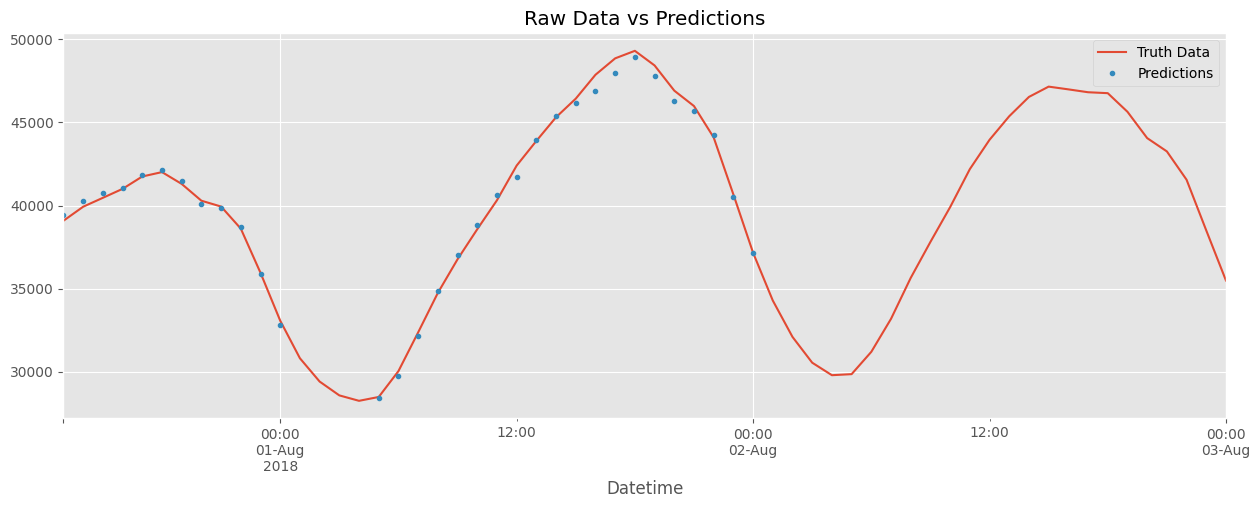

In [30]:
ax= df.iloc[-60:]['PJME_MW'].plot(figsize=(15,5), title='Week of Data')
df.iloc[-60:]['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data vs Predictions')
plt.show()

In [31]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))

In [32]:
test['error'] = np.abs(test[target]- test['prediction'])

In [33]:
test['date'] = test.index.date

In [36]:
print(f"Best predictions: {test.groupby(['date'])['error'].mean().sort_values(ascending=False).tail(5)}")
print(f"Worst predictions: {test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(5)}")

Best predictions: date
2018-05-22    126.455868
2018-05-06    121.738616
2018-04-25    120.112164
2018-05-17    119.613963
2018-08-02     25.520185
Name: error, dtype: float64
Worst predictions: date
2018-01-03    782.979691
2018-01-01    698.482942
2018-07-03    667.931299
2018-01-05    633.497538
2018-07-02    563.363567
Name: error, dtype: float64


<Axes: xlabel='Datetime'>

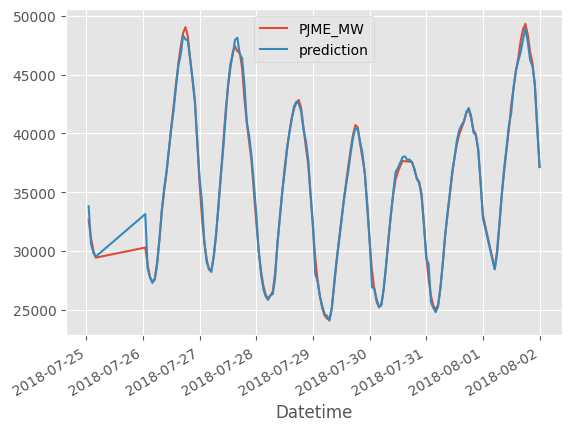

In [37]:
test[["PJME_MW", "prediction"]][:168].plot()

<Axes: xlabel='Datetime'>

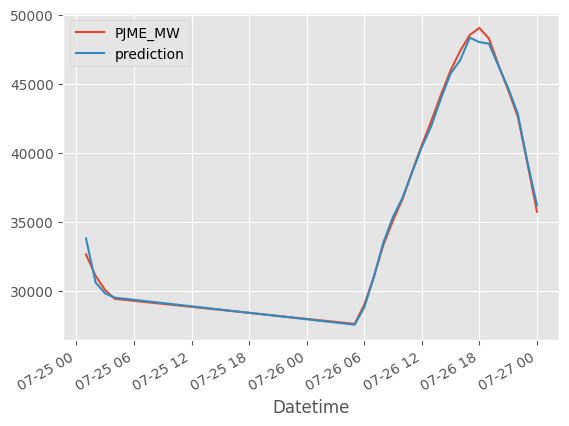

In [38]:
test[["PJME_MW", "prediction"]][144:168].plot()